In [1]:
# Cell 1 ‑‑‑ imports and cube loading
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u
from astropy import constants as c

# --------- file location (edit if needed) ----------
cube_path = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
print("Loading:", cube_path.resolve())

with fits.open(cube_path) as hdul:
    data = hdul["DATA"].data.astype(np.float32)   # (nz, ny, nx)
    stat = hdul["STAT"].data.astype(np.float32)
    dq   = hdul["DQ"].data.astype(np.uint8)
    hdr  = hdul["DATA"].header

nz, ny, nx = data.shape
print(f"Cube dimensions  →  nz = {nz},  ny = {ny},  nx = {nx}")
hdr


Loading: /g/data/jh2/rh2802/ICRAR/data/IC3392/IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits
Cube dimensions  →  nz = 3761,  ny = 438,  nx = 437


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
NAXIS3  =                 3761                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'             

In [2]:
# Cell 2  –– wavelength array (Å), λ‑cut, velocity scale
from astropy.wcs import WCS

# --- 2.1 build wavelength array in Å ---
wcs_3d = WCS(hdr)                       # 3‑D WCS (RA, Dec, λ)
spec_pix = np.arange(nz)                # spectral pixel indices (0 … nz‑1)

# all_pix2world returns metres for the spectral axis in this cube → convert to Å
lam_m  = wcs_3d.all_pix2world(
             np.zeros_like(spec_pix),   # dummy RA
             np.zeros_like(spec_pix),   # dummy Dec
             spec_pix,                  # spectral pixel
             0)[2]                      # wavelength [m]
lam_ang = lam_m * 1e10                  # metres → Å

# --- 2.2 keep only λ < 7000 Å ---
cut = (lam_ang >= 4750.0) & (lam_ang <= 7000.0)
lam_ang = lam_ang[cut]
data    = data[cut, :, :]
stat    = stat[cut, :, :]
dq      = dq[cut,   :, :]
nz      = lam_ang.size                 # update nz after trimming
print(f"After λ‑cut (<=7000 Å)  →  nz = {nz}")

# --- 2.3 compute velocity scale (km s⁻¹ per pixel) ---
c_kms   = c.c.to(u.km/u.s).value        # 299 792.458
dlnλ    = np.diff(np.log(lam_ang))  # dlnλ in Å
velscale = np.min(c_kms * dlnλ) # km/s per pixel
print(f"Velocity scale (min)  →  velscale = {velscale:.2f} km/s")


After λ‑cut (<=7000 Å)  →  nz = 1800
Velocity scale (min)  →  velscale = 53.55 km/s


Integrated spectrum built:
   simple‑sum shape    : (1800,)


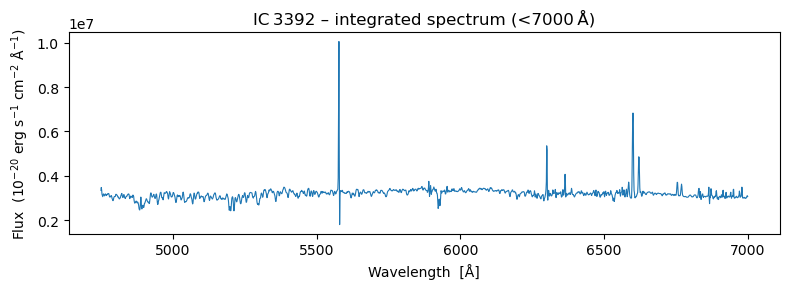

In [3]:
# Cell 3 –– integrate cube to 1‑D spectrum + noise  (v2: NaN‑safe)
# ----------------------------------------------------------------

# ---- 3.1 simple‑sum spectrum ----
flux_sum  = np.nansum(data, axis=(1, 2))          # erg s⁻¹ cm⁻² Å⁻¹
noise_wgt = np.sqrt(np.nansum(stat, axis=(1, 2)))  # shape = (nz,)

print("Integrated spectrum built:")
print(f"   simple‑sum shape    : {flux_sum.shape}")

# ---- 3.2 quick plot ----
plt.figure(figsize=(8, 3))
plt.plot(lam_ang, flux_sum, lw=0.8)
plt.xlabel("Wavelength  [Å]")
plt.ylabel(r"Flux  ($10^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")
plt.title("IC 3392 – integrated spectrum (<7000 Å)")
plt.tight_layout();  plt.show()


Hα‑based red‑shift  z = 0.00567   (v ≈ 1699.3 km/s)
Masked wavelength bins : 328 of 1800 (18.2 %)


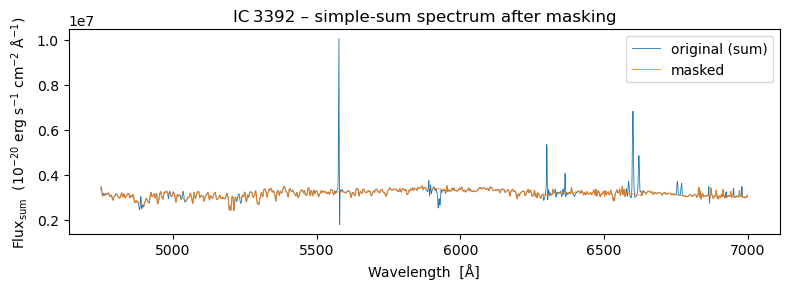

In [4]:
# Cell 4 –– red‑shift guess & dual‑spectra masking (sky ≠ red‑shifted)
# -------------------------------------------------------------------
import numpy as np

# -- 4.1  red‑shift from Hα using the simple‑sum spectrum --------------
h_alpha_lab = 6562.8
win = (lam_ang > 6500) & (lam_ang < 6700)
lam_peak = lam_ang[win][np.nanargmax(flux_sum[win])]
z_guess  = lam_peak / h_alpha_lab - 1
v_guess  = z_guess * c_kms
print(f"Hα‑based red‑shift  z = {z_guess:.5f}   (v ≈ {v_guess:.1f} km/s)")

# -- 4.2  read mask table ------------------------------------------------
mask_dtype = [('lam', 'f8'), ('width', 'f8'), ('comment', 'U32')]
mask_tbl  = np.genfromtxt("specMask_KIN.txt", dtype=mask_dtype,
                          comments='#', usecols=(0,1,2), encoding=None)

# -- 4.3  construct bad‑pixel mask --------------------------------------
mask_bad = np.zeros_like(lam_ang, dtype=bool)

for lam_rest, width_rest, comment in mask_tbl:
    # sky lines: use rest value directly (no z shift)
    if comment.strip().lower() == 'sky':
        lam_obs   = lam_rest
        width_obs = width_rest
    else:                       # nebular/emission lines → red‑shifted
        lam_obs   = lam_rest  * (1 + z_guess)
        width_obs = width_rest * (1 + z_guess)

    m = (lam_ang > lam_obs - width_obs/2) & (lam_ang < lam_obs + width_obs/2)
    mask_bad |= m

print(f"Masked wavelength bins : {mask_bad.sum()} of {lam_ang.size} "
      f"({100*mask_bad.mean():.1f} %)")

# --- 4.4 replace masked pixels with local mean along the wavelength axis ---

def fill_bad_1d(spec, bad):
    """
    spec : 1‑D array  (your flux vector)
    bad  : 1‑D bool   (True where you want to replace)
    Returns a *new* array with bad entries replaced by the
    mean of the nearest good pixels on either side.
    """
    filled = spec.copy()

    if bad.any():
        good = ~bad
        # np.interp does linear interpolation; for a single pixel gap
        # that is exactly the mean of its two neighbours
        filled[bad] = np.interp(np.flatnonzero(bad),         # x  to fill
                                np.flatnonzero(good),        # x of neighbours
                                spec[good])                  # y of neighbours
    return filled

# 1‑D masks (length = nz)
bad_1d = mask_bad.copy()

flux_sum_masked = fill_bad_1d(flux_sum, bad_1d)

# keep the noise = ∞ so pPXF still gives zero weight there
noise_wgt_masked = noise_wgt.copy()
noise_wgt_masked[bad_1d] = np.inf

# -- 4.5  quick visual check -----------------------
plt.figure(figsize=(8,3))
plt.plot(lam_ang, flux_sum,        lw=0.6, label='original (sum)')
plt.plot(lam_ang, flux_sum_masked, lw=0.8, label='masked', alpha=0.8)
plt.xlabel('Wavelength  [Å]')
plt.ylabel(r'Flux$_\mathrm{sum}$  (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title('IC 3392 – simple‑sum spectrum after masking')
plt.legend();  plt.tight_layout();  plt.show()

# Extract the region that we maks out
lam_ang_masked = lam_ang[bad_1d]
flux_sum_masked = flux_sum_masked[bad_1d]

# ---- outputs for Cell 5 ----
# lam_ang, flux_wgt_masked, noise_wgt_masked, flux_sum_masked


In [10]:
# Cell 5 –– log‑rebinning the chosen 1‑D spectrum
# -----------------------------------------------
from ppxf import ppxf_util

# ----- 5.0  get spectrum -----

flux_1d_raw  = flux_sum_masked
# noise from summed variances (shot‑noise approximation)
noise_1d_raw = np.sqrt(np.nansum(stat, axis=(1,2)))
noise_1d_raw[mask_bad] = np.inf
spec_tag     = "simple‑sum"

print(f"Preparing {spec_tag} spectrum for pPXF …")

# --- 5.0a  make NaN‑/Inf‑safe copies ---------------------------------
flux_1d  = np.nan_to_num(flux_1d_raw,  nan=0.0, posinf=0.0, neginf=0.0)
noise_1d = np.nan_to_num(noise_1d_raw, nan=np.inf, posinf=np.inf, neginf=np.inf)
noise_1d[noise_1d <= 0] = np.inf

# --- 5.1  finite wavelength range ------------------------------------
lam_finite = lam_ang[np.isfinite(flux_1d)]
lam_range  = [lam_finite.min(), lam_finite.max()]      # Å

# --- 5.2  log‑rebin flux and noise -----------------------------------
# 5.2a  initial rebin just to measure velscale_out
_, _, velscale_out = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d, velscale=velscale, flux=True)

# 5.2b  rebin flux & noise *with* the measured velscale_out
log_flux, log_lam, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d,
    velscale=velscale_out, flux=True)

log_noise, _, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], noise_1d,
    velscale=velscale_out, flux=False)

# 5.3  clean the noise as before
bad = ~np.isfinite(log_noise) | (log_noise <= 0)
log_noise[bad] = np.inf
log_noise[~np.isfinite(log_noise) | (log_noise <= 0)] = np.inf
# Force NaN/Inf to be median noise
log_noise[~np.isfinite(log_noise)] = np.nanmedian(log_noise)
# # Force zero flux to be median values
# log_flux[log_flux == 0] = np.nanmedian(log_flux)

print(f"Log‑grid length : {log_flux.size} pixels")
print(f"velscale        : {velscale_out:.3f} km/s")

assert np.isclose(velscale_out, velscale), \
       "Warning: velscale mismatch! Check your data."

# ---- outputs for the next cell ----
#   log_flux, log_noise, log_lam, velscale_out, z_guess


Preparing simple‑sum spectrum for pPXF …


IndexError: boolean index did not match indexed array along axis 0; size of axis is 1800 but size of corresponding boolean axis is 328

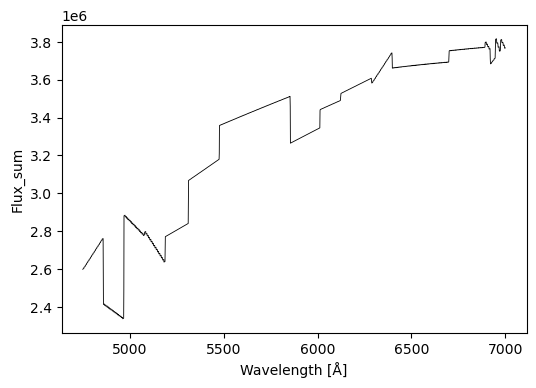

In [6]:
plt.figure(figsize=(6,4))
plt.plot(np.exp(log_lam), log_flux, 'k-', lw=0.6)          # flux in Å again
plt.xlabel('Wavelength [Å]'); plt.ylabel('Flux_sum'); plt.show()

In [7]:
# Cell 6 –– load E‑MILES templates, match FWHM, log‑rebin
# -------------------------------------------------------
from pathlib import Path
from urllib import request
import numpy as np
from scipy.interpolate import interp1d
import ppxf.sps_util as lib
from ppxf import ppxf_util

# ------------------------------------------------------------------
# 6.1  Download the E‑MILES bundle once (if not already present)
# ------------------------------------------------------------------
ppxf_dir = Path(lib.__file__).parent
basename = "spectra_emiles_9.0.npz"
filename = ppxf_dir / "sps_models" / basename
filename.parent.mkdir(exist_ok=True)

if not filename.is_file():
    url = f"https://raw.githubusercontent.com/micappe/ppxf_data/main/{basename}"
    print("Downloading E‑MILES templates …")
    request.urlretrieve(url, filename)

print("Loading E‑MILES SSP grid …")
sps = lib.sps_lib(filename, velscale_out, fwhm_gal=None,
                  norm_range=[4750, 7000]
                  )                     # same λ‑cut as galaxy

templates_hr = sps.templates          # (n_wave, n_age, n_Z)
lam_temp_hr  = sps.lam_temp           # length 18 998 Å

# ------------------------------------------------------------------
# 6.2  Retrieve template FWHM and MUSE LSF on the same grid
# ------------------------------------------------------------------
with np.load(filename) as f:
    fwhm_temp = f["fwhm"]             # length 16 675 in this file

# interpolate to template λ‑grid if needed
if fwhm_temp.size != lam_temp_hr.size:
    fwhm_temp = interp1d(
        np.linspace(0, 1, fwhm_temp.size),
        fwhm_temp, kind="linear", bounds_error=False,
        fill_value=fwhm_temp[-1])(np.linspace(0, 1, lam_temp_hr.size))

# Emsellem+2022 wavelength‑dependent MUSE FWHM  (Å)
fwhm_muse = 5.866e-8*lam_temp_hr**2 - 9.187e-4*lam_temp_hr + 6.040

# ------------------------------------------------------------------
# 6.3  Convolve every template to MUSE resolution
# ------------------------------------------------------------------
n_wave, n_age, n_met = templates_hr.shape
templates_flat = templates_hr.reshape(n_wave, -1).T          # (150, 18998)

sigma_muse  = fwhm_muse / 2.355
sigma_temp  = fwhm_temp / 2.355
sigma_diff  = np.sqrt(np.clip(sigma_muse**2 - sigma_temp**2, 0, None))
sigma_pix   = sigma_diff / np.gradient(lam_temp_hr)          # in pixels

templates_conv = np.empty_like(templates_flat)
for k, spec in enumerate(templates_flat):
    templates_conv[k] = ppxf_util.gaussian_filter1d(spec, sigma_pix)

# ------------------------------------------------------------------
# 6.4  Log‑rebin to galaxy velscale  →  (n_pix, n_templates)
# ------------------------------------------------------------------
log_temp, log_lam_temp, _ = ppxf_util.log_rebin(
        [lam_ang[0], lam_ang[-1]],
        templates_conv.T,                  # (n_wave, n_templates)
        velscale=velscale_out,
        flux=True)                         # returns (n_pix, n_templates)

# ------------------------------------------------------------------
# 6.5  Match the same size
# ------------------------------------------------------------------
minpix = min(log_temp.shape[0], log_flux.shape[0])   # find the minimum
log_temp      = log_temp[:, :minpix]                 # trim template matrix
log_lam_temp  = log_lam_temp[:minpix]                # same for λ axis
log_flux      = log_flux[:minpix]                    # trim galaxy flux
log_noise     = log_noise[:minpix]                   # trim galaxy noise
log_lam       = log_lam[:minpix]                     # trim galaxy λ
print(f"Pixel match achieved → templates = galaxy = {minpix}")

print("Template matrix :", log_temp.shape, "(n_pix, n_templates)")
print("Galaxy flux     :", log_flux.shape)
print("Galaxy noise    :", log_noise.shape)

# ---- outputs for Cell 7 ------------------------------------------------
# log_temp  (n_pix, n_templates)
# log_lam_temp, log_flux, log_noise, velscale_out


Loading E‑MILES SSP grid …
Pixel match achieved → templates = galaxy = 2170
Template matrix : (2170, 150) (n_pix, n_templates)
Galaxy flux     : (2170,)
Galaxy noise    : (2170,)


Outliers: 2023
Outliers: 1
Outliers: 1
Outliers: 2038
Outliers: 3
Outliers: 2028
Outliers: 2
Outliers: 1
Outliers: 2001
Outliers: 3
Outliers: 1
Outliers: 1998
Outliers: 5
Outliers: 1
 Best Fit:       Vel     sigma
 comp.  0:        48        88
chi2/DOF: 1.292; DOF: 164; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 122; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
V = 48.417 km/s,  σ = 88.322 km/s


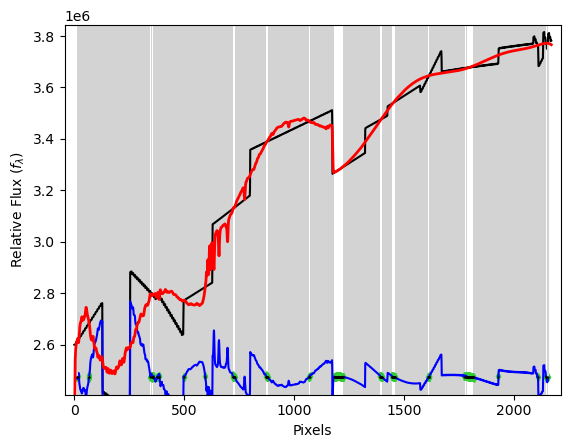

In [8]:
from ppxf import ppxf

start_V  = 0          # ≈ 1 650 km/s
start_sig= velscale_out                     # km/s initial guess

pp = ppxf.ppxf(
    templates   = log_temp,         # (n_pix, n_templates)
    galaxy      = log_flux,
    noise       = log_noise,
    velscale    = velscale_out,
    start       = [start_V, start_sig],
    degree      = 12,               # additive
    mdegree     = 0,                # multiplicative (flat)
    moments     = 2,
    clean       = True,
    plot        = True)

print(f"V = {pp.sol[0]:.3f} km/s,  σ = {pp.sol[1]:.3f} km/s")


In [9]:
# composite stellar mass, r‑band light and M/L
# ------------------------------------------------------

import numpy as np
from astropy import units as u, constants as c

# ---------- Galaxy continuum luminosity from the fit --------------
D = 16.5 * u.Mpc                                        # Virgo distance
erg_to_Lsun = (1*u.erg/u.s / c.L_sun).to('').value      # 2.613×10⁻³⁴

F_lambda = log_flux * 1e-20                             # erg s⁻¹ cm⁻² Å⁻¹
L_lambda = F_lambda * 4*np.pi*(D.to('cm').value)**2 * erg_to_Lsun   # L☉ Å⁻¹
L_gal    = np.trapezoid(L_lambda, np.exp(log_lam))          # L☉

# ---------- Composite M/L from pPXF weights ------------------------
reg_dim = sps.templates.shape[1:]
weights = pp.weights.reshape(reg_dim)/pp.weights.sum()                                           # enforce Σw = 1

ML_pop = sps.mass_to_light(weights, band="SDSS/r", redshift=pp.sol[0]/c_kms,)                     # intrinsic M/L (dimensionless)

# ---------- Physical stellar mass inside the MUSE aperture --------
from speclite import filters
f_r   = filters.load_filter('sdss2010-r')
lam_r = f_r.wavelength
R_r   = f_r.response

# best‑fit continuum in physical units (L_sun Å⁻¹)
cont_L = pp.bestfit * 1e-20 * 4*np.pi*(D.to('cm').value)**2 * erg_to_Lsun

L_r    = np.trapezoid( np.interp(lam_r, np.exp(log_lam), cont_L) * R_r, lam_r )  # L_sun
M_star = ML_pop * L_r

print(f"log L  (aperture) : {np.log10(L_gal):.3f}  L☉")
print(f"Log L  (r-band)   : {np.log10(L_r):.3f}  L☉")
print(f"M/L (population)  : {ML_pop:.3f}  M☉/L☉")
print(f"log M_star          : {np.log10(M_star):.3f}  M☉")


(M*/L)=0.1562 (SDSS/r at z=0.0002)


ModuleNotFoundError: No module named 'speclite'